In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## Population decoding

In this notebook, it will be shown how the technique called population vector decoding can be used to read out information from neural responses. For this demonstration, two different model neurons will be used

### M1 motor neurons

The primary motor cortex contains neurons that fire in relation to specific motor actions that are performed. The example which will be used, corresponds to a neuron that fires selectively to an arm movement in a particular direction. This was studies by Georgopoulos in a task in which monkeys had to place their arm in a central location, and were trained to move their arm in different directions. The tuning curve of such a neuron is described by the following equation:

$$f(s) = r_0 + ( r_{max} - r_0) cos (s - s_{pref})$$

where $r_0$ represents a baseline firing rate, $r_max$ represents the maximum firing rate, and $s_pref$ represents the prefered direction of the neuron. For this a function is defined, with some default parameters that are given in Dayan and Abbott(2000). The tuning curve for the default parameter values is also plotted.

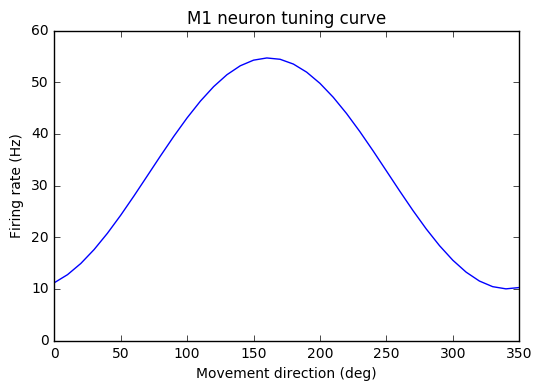

In [8]:
def M1_response( s, s_pref = 161.25, r_max = 54.69, r_0 = 32.34):
    s_pref = np.deg2rad(s_pref)
    s = np.deg2rad(s)
    
    r = r_0 + (r_max - r_0) * np.cos( s - s_pref)
    r[r<0] = 0
    return r

s = np.arange(0,360,10)
r = M1_response(s)
plt.plot(s,r)
plt.xlabel('Movement direction (deg)')
plt.ylabel('Firing rate (Hz)')
plt.title('M1 neuron tuning curve')

### Cricket cercal neurons
Another example of cosine tuning curves can be found in the interneurons of the cricket cercal system. This systems contains neurons that are tuned to one of four possible directions, but their tuning curves are given without a baseline firing rate so that they are completely silent for wind directions opposite to their prefered direction:

$$f(s) = r_{max} cos (s - s_{pref})$$

Note that the actual paper by Theunissen and Miller contains an extra parameter to describe the normalized tuning curves:

$$f(s) = \frac{cos(s - s_{pref}) - a}{1-a} $$

Tuning curves for each model are defined, but only the first will be used in demonstration of the population vector method.


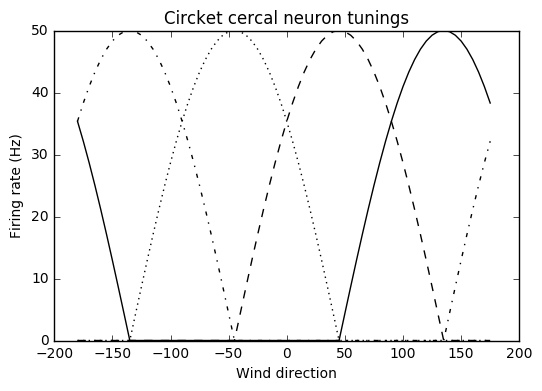

In [22]:
def cricket_response_1(s, s_pref, r_max = 50):
    s = np.deg2rad(s)
    s_pref = np.deg2rad(s_pref)
    r = r_max*np.cos(s-s_pref)
    r[r<0] = 0
    return r

def cricket_response_2(s, s_pref, r_max = 50, a = -0.14):
    s = np.deg2rad(s)
    s_pref = np.deg2rad(s_pref)
    r = (r_max/(1-a))*(np.cos(s-s_pref)-a)
    r[r<0] = 0
    return r

prefered_directions = np.array([45, 135, -135, -45])
wind_direction = np.arange(-180,180,5)
ls=['--k','-k','-.k',':k']
for i in range(len(prefered_directions)):
    plt.plot(wind_direction, cricket_response_1(wind_direction, prefered_directions[i]),ls[i])
plt.title('Circket cercal neuron tunings')
plt.xlabel('Wind direction')
plt.ylabel('Firing rate (Hz)')

## Decoding cricket cercal cell responses
To illustrate the population vector method, note that each of the cercal cell's prefered directions can be represented by a unit vector in 2D space:

$$\vec{c}_a = cos(s_{pref})\hat{x} + sin(s_{pref})\hat{y}$$

With this representation, a neuron's spike count in a single trial can be considered a vote for that neurons prefered direction: a very high spike count indicates high confidence that the wind direction corresponds to the prefered direction, while zero spikes indicate that the wind direction doesn't correspond to the prefered direction at all. 

The following code simulates a single trial with a true wind direction of 45 degrees. First, each of the prefered directions are plotted as unit vectors, followed by a plot in which the unit vectors are weighted by the trial spike count. From this, the population vector can be constructed:

$$\vec{p} = \sum_{a}r_a \vec{c}_a$$


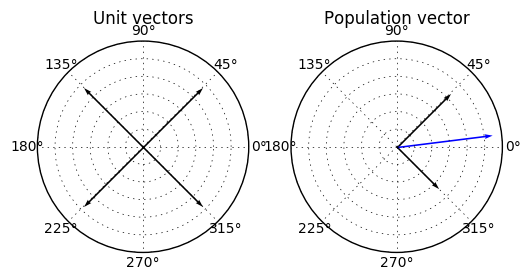

In [73]:
true_direction = 0

spike_count = np.random.poisson(cricket_response_1(true_direction,prefered_directions))/50.0

c_a = np.array([np.cos(np.deg2rad(prefered_directions)),np.sin(np.deg2rad(prefered_directions))])

pop_vector = np.sum(spike_count*c_a,1)

# Plot the unit direction vectors
ax = plt.subplot(121,projection = 'polar')
for i in range(len(prefered_directions)):
    ax.quiver(0.0, 0.0, c_a[0,i],c_a[1,i], units ='x', scale = 0.4)
ax.set_yticklabels([])
ax.set_title('Unit vectors')

# Plot the weighted unit vectors and the population vector
ax = plt.subplot(122,projection = 'polar')
for i in range(len(prefered_directions)):
    ax.quiver(0.0, 0.0, spike_count[i]*c_a[0,i],spike_count[i]*c_a[1,i], units ='x', scale = 0.4)
ax.quiver(0.0, 0.0, pop_vector[0],pop_vector[1], units = 'x', scale = 0.4,color='b')
ax.set_yticklabels([])
ax.set_title('Population vector')

The performance of this method can be assessed by running multiple trials at different true wind directions and recording the error on each trial. On each trial, the error is the square of the difference between the true wind direction and the estimated population direction. The performance of the method is evaluated by plotting the square root of the mean error for each wind direction.

C:\Program Files (x86)\Anaconda2\lib\site-packages\ipykernel\__main__.py:13: RuntimeWarning: invalid value encountered in arccos


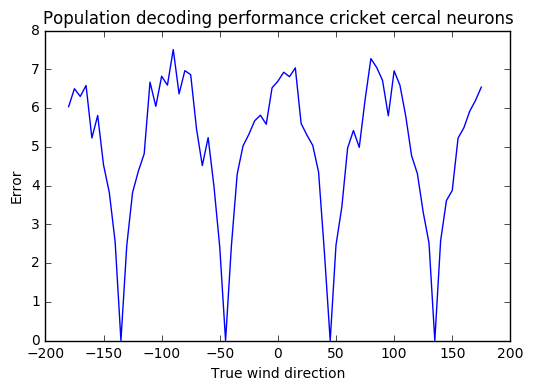

In [98]:
n_trials = 100
true_directions = np.arange(-180,180,5)
error = np.zeros((len(true_directions),n_trials))

for i,s in enumerate(true_directions):
    v_true = np.array([np.cos(np.deg2rad(s)),np.sin(np.deg2rad(s))])
    
    for trial in range(n_trials):
        r = cricket_response_1(s,prefered_directions)
        spike_count = np.random.poisson(r)
        
        v_pop = np.sum(spike_count*c_a,1)
        diff = np.arccos(np.dot(v_true,v_pop)/(np.linalg.norm(v_pop)*np.linalg.norm(v_true)))
        error[i,trial] = np.square(np.rad2deg(diff))
       
mean_error = np.sqrt(np.nanmean(error,1))
plt.plot(true_directions,mean_error)
plt.xlabel('True wind direction')
plt.ylabel('Error')
plt.title('Population decoding performance cricket cercal neurons')

## Decoding M1 motor neuron responses

A similar approach can be used to simulate M1 neuron responses. For these neurons, prefered direction are spread more uniformly across the unit circle, and a variable spread is used to indicate the separation between optimal directions of the tuning curves. With more neurons, a better estimate of the population vector can be constructed, which leads to a lower decoding error.

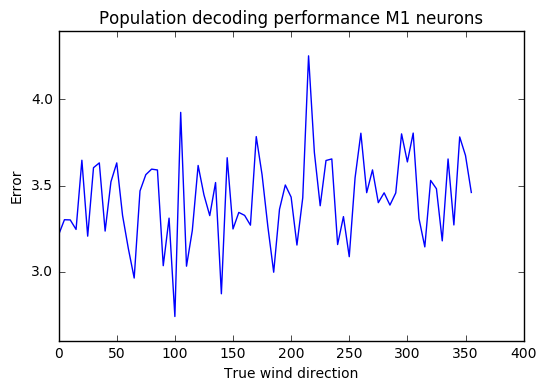

In [115]:
n_trials = 100
spread   = 10
prefered_directions = np.arange(0,360, spread)
arm_directions = np.arange(0,360,5)
error = np.zeros((len(arm_directions),n_trials))
m_a = np.array([np.cos(np.deg2rad(prefered_directions)),np.sin(np.deg2rad(prefered_directions))])

for i,s in enumerate(arm_directions):
    v_true = np.array([np.cos(np.deg2rad(s)), np.sin(np.deg2rad(s))])
    
    for trial in range(n_trials):
        r = M1_response(s,prefered_directions)
        spike_count = np.random.poisson(r)
        
        v_pop = np.sum(spike_count*m_a,1)
        diff = np.arccos(np.dot(v_true,v_pop)/(np.linalg.norm(v_pop)*np.linalg.norm(v_true)))
        error[i,trial] = np.square(np.rad2deg(diff))
        
mean_error = np.sqrt(np.nanmean(error,1))
plt.plot(arm_directions,mean_error)
plt.xlabel('True wind direction')
plt.ylabel('Error')
plt.title('Population decoding performance M1 neurons')

Several aspects of population vector decoding could be explored starting from this code:
* The current code does not use any normalization or correction for mean firing rates in constructing the population vector. You can estimate the effects of these corrections in the case that all neurons in the population share the same parameters (except for the prefered direction) or when neurons differ in their maximal and mean firing rate
* Investigate the effect of spread on decoding in M1 neurons
* Investigate the effect of having multiple cercal 